By this point, your data calibration should be nearly complete! The last step necessary for you to get a quick look at your extracted spectral energy distribution (SED) is called a "flux extraction." Among modern reduction pipelines, a handful of flux extraction algorithms have become common (most common are the "boxcar" and "optimal" extraction algorithms).

In this section, we discuss a few algorithms ```specsuite``` can use to extract flux from your calibrated science exposures.

In [1]:
import specsuite as ss

# Defines where to look for data
DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# Loads calibration exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT
)
arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Loads science exposures
science = ss.collect_images_array(
    DATA_PATH,
    "toi3884",
    crop_bds=DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Extracts background emissions
locs, _ = ss.find_cal_lines(arclamp, std_variation = 200)
warp_model = ss.generate_warp_model(arclamp, locs)
backgrounds = ss.extract_background(science, warp_model, mask_region = (40, 80))

science -= backgrounds

## **Basic Usage**
As of now, there are only two available methods for extracting flux from your science exposure.

### _Boxcar Extraction_
Let **D**(x, y) represent a single background-contaminated exposure where the values at every point has units of photo-electrons. Similarly, let **S**(x, y) represent the strength of the background across the image (also in units of photo-electrons). The simplest possible estimate of our signal is known as a *boxcar extraction* where...

\begin{equation*}
    f(x) = \sum_{i} \left[ \textbf{D}(x, y_i) - \textbf{S}(x, y_i) \right]
\end{equation*}

is the extracted flux. The uncertainty of this signal is given by...

\begin{equation*}
    \sigma(x) = \sqrt{RN^2 + \sum_{i} \textbf{D}(x, y_i)}
\end{equation*}

where RN is the "read noise" of the detector. This is a quick and simple extraction method, but has several noteable drawbacks. Firstly, if cosmic ray contamination is present in your data, then the extracted flux will have erroneous and sudden jumps in brigthness for dispersion-axis pixels with any level of contamination. Secondly, the uncertainty of your extracted spectra is artificially inflated by dimly-illuminated regions of your detector.

Despite these issues, it can be a useful for first looks! Here is a simple example call for our KOSMOS data...

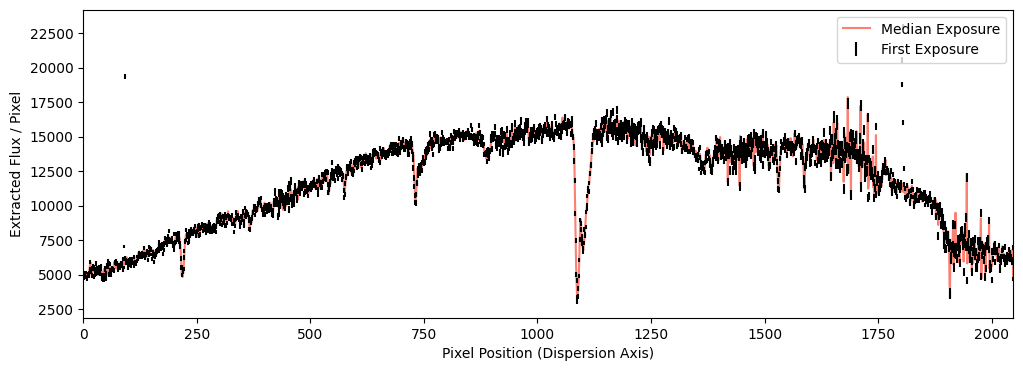

In [2]:
boxcar_flux, boxcar_errs = ss.boxcar_extraction(
    science,
    backgrounds,
    RN = 6.0,
    debug = True,
)

Notice the prominant cosmic ray contamination and poor SNR for dispersion-axis pixels with a strong background emission. While neither can be entirely corrected for, the next extraction method uses a statistical argument to mitigate both of these non-ideal features.

### _What is Horne's (Optimal) Extraction?_
**Horne's extraction routine** uses an iterative process to revise its estimate of the variance (**V**(x, y)) until an optimal SNR is reached. Please refer to **[Horne (1986)](https://articles.adsabs.harvard.edu/pdf/1986PASP...98..609H)** for a complete discussion of this process. One important component of the optimal extraction routine is the spatial profile **P**. This profile describes how likely a photon from a point-source target is to land at any pixel along the cross-dispersion axis.

We assume that each trace profile is well described by a Moffat or Gaussian profile, and that the parameters of the profile changes smoothly along the dispersion axis. If true, we are able to fit a 1D profile to each column in a science exposure, then fit a low-order polynomial to predict how each profile parameter changes along the dispersion axis. In practice, this can process can fail for faint columns and columns with significant cosmic ray contamination. We address both of these by fitting 1D profiles to a binned version of the science exposure.

### _Finding a Spatial Profile_
For ground-based data, we have found a Moffat profile to be a better description of our data than a Gaussian profile. Here is the extracted spatial profile for a single exposure using a Moffat profile...

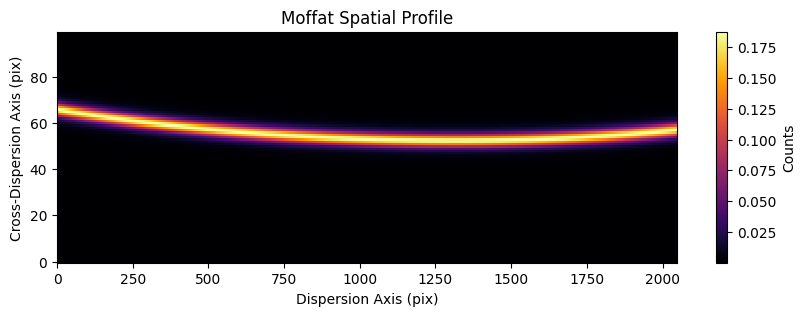

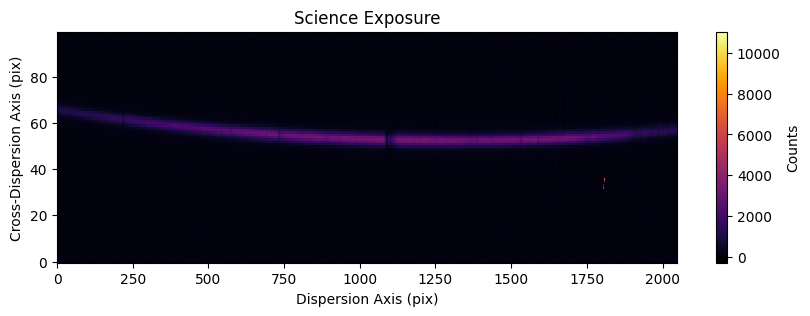

In [3]:
P_moffat = ss.generate_spatial_profile(
    image = science[0],
    profile = "moffat",
)

ss.plot_image(P_moffat, title = "Moffat Spatial Profile")
ss.plot_image(science[0], title = "Science Exposure")

If you want to use a Gaussian profile, that option is still available, but you may need to tweak some optional settings to get a high-quality fit. For example, for our KOSMOS data, we need to slightly increase the bin size and disable the "repeat" argument (this runs a second fitting routine to try and improve the quality of the 1D profile fits). Doing so gives us...

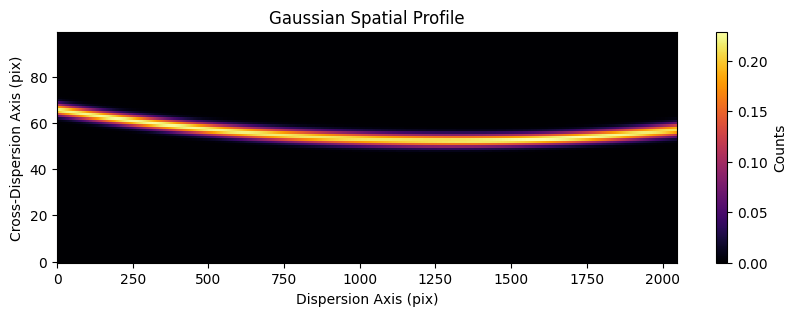

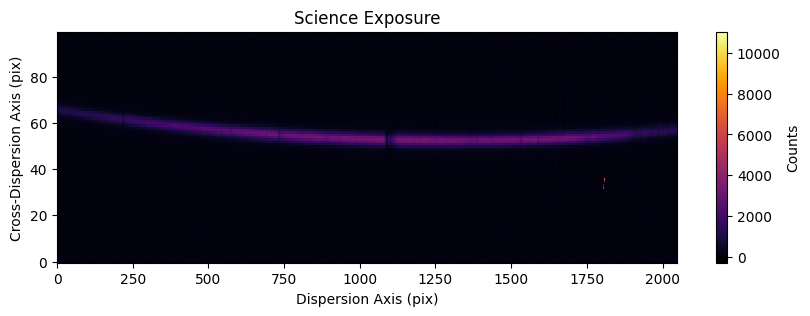

In [4]:
P_gaussian = ss.generate_spatial_profile(
    image = science[0],
    profile = "gaussian",
    bin_size = 16,
    repeat = False,
)

ss.plot_image(P_gaussian, title = "Gaussian Spatial Profile")
ss.plot_image(science[0], title = "Science Exposure")

Depending on your specific data / analysis, either of these could be a suitable choice! So long as the spatial profile appears to capture the shape of your signal reasonably well, the profile-weighted extraction should work as expected.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For ground-based data, a Gaussian spatial profile is usually inaccurate. This is due to atmospheric effects blurring and is most significant for the wings of the profile. Since some modern reductions have found success with using a Moffat profile instead, we generally default to that choice as well. If you are processing data from a ground-based observatory and notice odd residuals toward the wings of your trace, double-check that you are using a Moffat profile in your reduction.
    </p>
</div>

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
        The Moffat profile we use is not completely accurate. For reference, the Moffat profile adopted by <a href="https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat1D.html"><strong>astropy</strong></a> is...
        \begin{equation}
        f(x) = A \left[ \frac{(x - x_0)^2}{\gamma^2} \right]^{-\alpha}.
        \end{equation}
        If gamma and alpha were both left as free parameters, we found that fits struggled to converge to a single, consistent answer. We address this by setting alpha to a constant (2.5). This choice is arbitrary, but we have found that it consistently results in a higher quality of fit.
    </p>
</div>

### _Profile-Weighted Extraction_
In Horne's optimal extraction algorithm, the flux is given by...
$$
\begin{equation}
f(x) = \frac{\sum_y \textbf{M} \textbf{P} (\textbf{D} - \textbf{S}) / \textbf{V}}{\sum_y \textbf{M} \textbf{P}^2 / \textbf{V}}
\end{equation}
$$
with a variance...
$$
\begin{equation}
\text{var}[f](x) = \frac{\sum_y \textbf{M} \textbf{P}}{\sum_y \textbf{M} \textbf{P}^2 / \textbf{V}}.
\end{equation}
$$
We decided to remove the outlier masking during our extraction. This means that cosmic ray contamination (and any other source of outliers) will no longer be masked out in the way outlined in Horne's original paper. Even without the cosmic ray masking, the quality of the extracted SED is significantly highter...

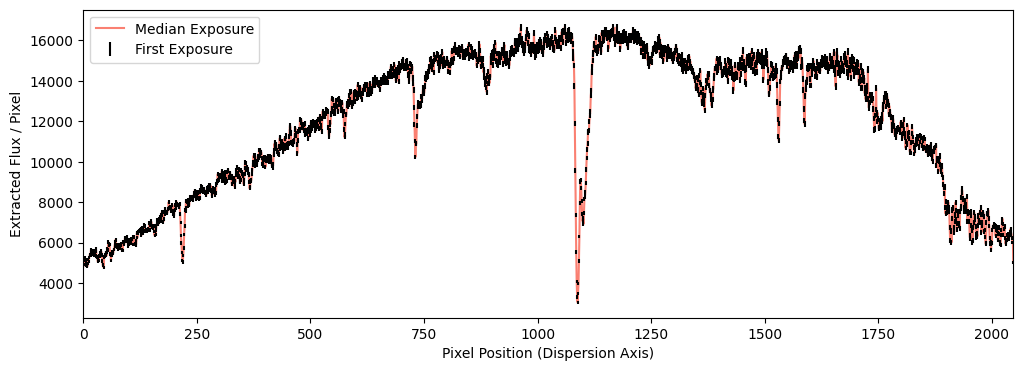

In [5]:
optimal_flux, optimal_err = ss.horne_extraction(
    images = science[0],
    backgrounds = backgrounds[0],
    profile = "moffat",
    RN = 6.0,
    debug = True,
)

## __Common Errors__

### _Bad Spatial Profile_

If you are using the ```horne_extraction()```, it is important to make sure that the spatial profiles ```specsuite``` is generating are accurate. For example, the following spatial profile would result in an extremely poor flux extraction...

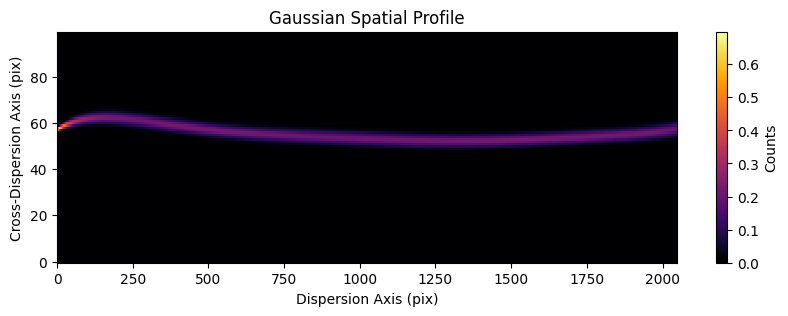

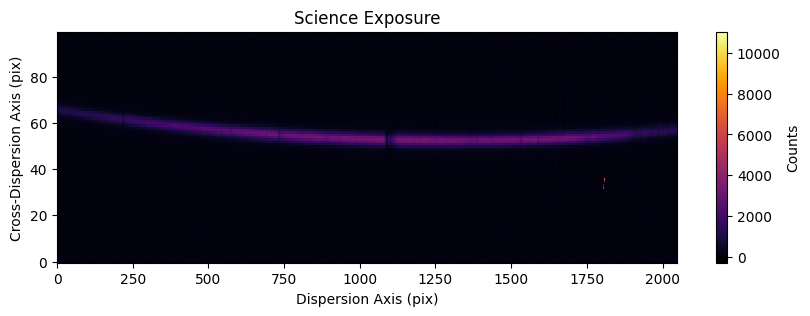

In [6]:
P_gaussian = ss.generate_spatial_profile(
    image = science[0],
    profile = "gaussian",
)

ss.plot_image(P_gaussian, title = "Gaussian Spatial Profile")
ss.plot_image(science[0], title = "Science Exposure")

We can see that something weird is happening at the leftmost edge of the spatial profile. This is a situation where the optional debugging plots could be useful...

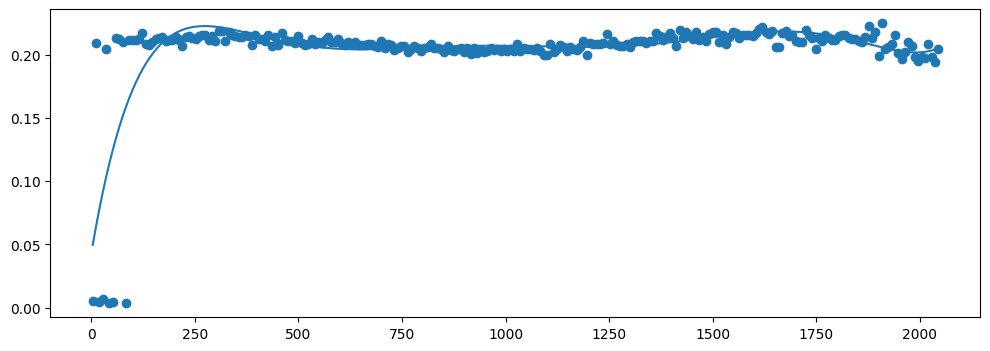

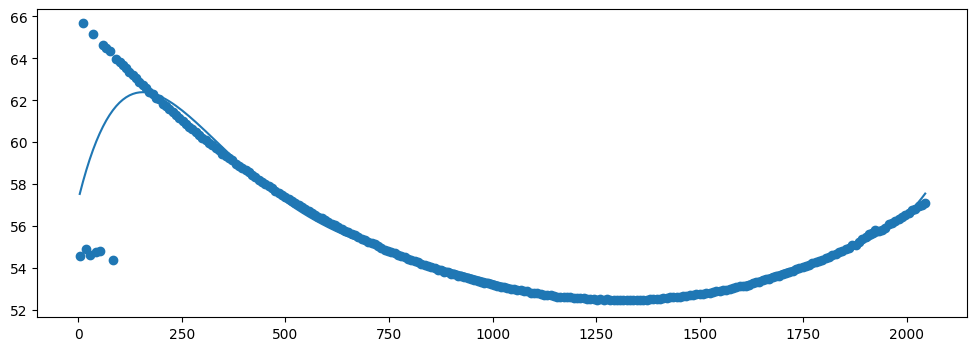

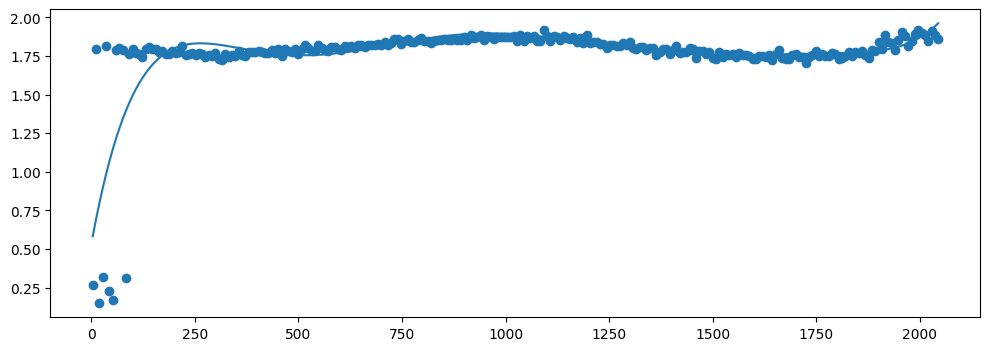

In [7]:
P_gaussian = ss.generate_spatial_profile(
    image = science[0],
    profile = "gaussian",
    debug = True,
)

Here we see the polynomial fits to each Gaussian parameters (amplitude, mean, sigma) for each location along the dispersion axis. This clearly indicates that some erroneous fits at the left end of the detector are strongly biasing our spatial profile. To fix this, we can try messing with some of ```generate_spatial_profile()```'s the optional parameters. In this particular case, simply using ```repeat=False``` is enough to cause a significant jump in quality!

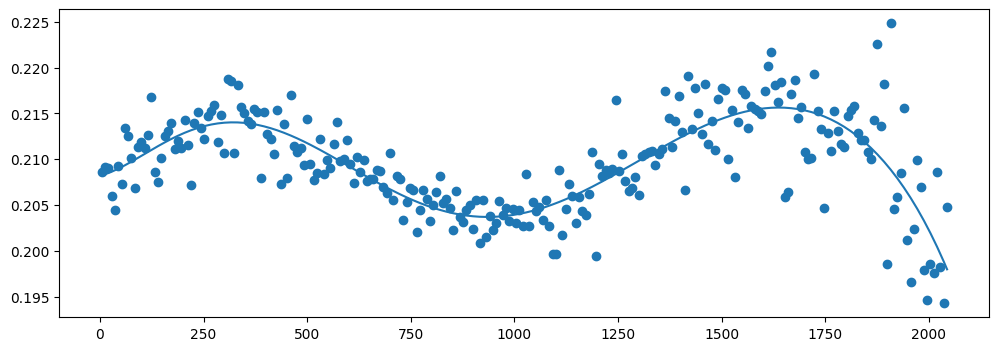

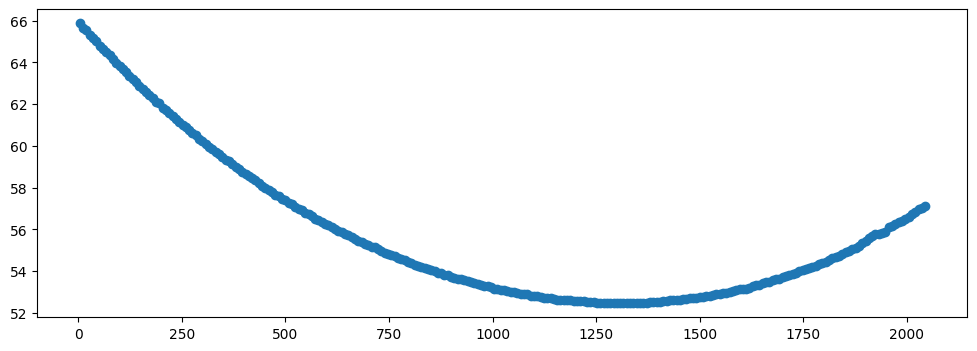

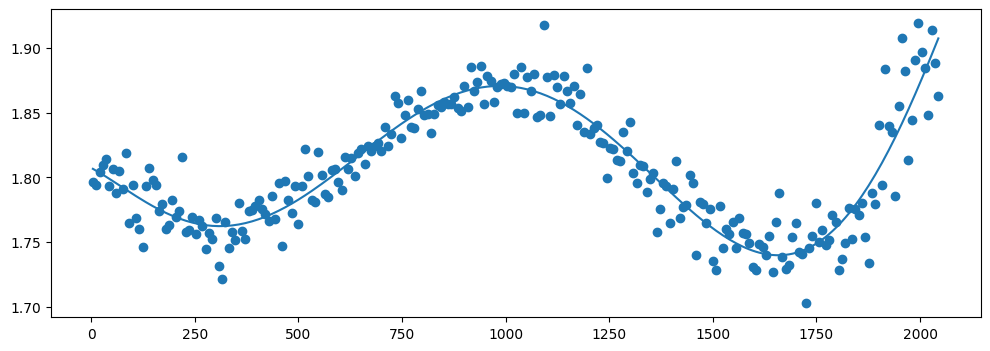

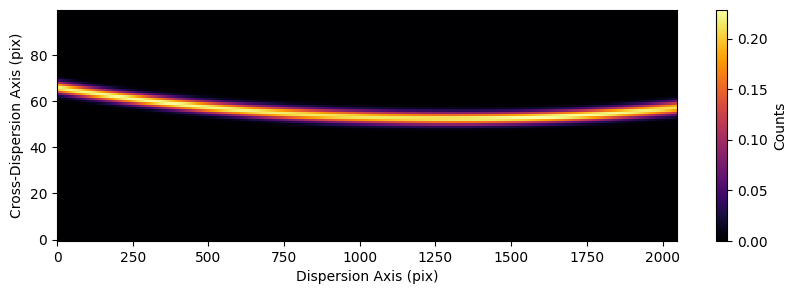

In [8]:
P_gaussian = ss.generate_spatial_profile(
    image = science[0],
    profile = "gaussian",
    repeat = False,
    debug = True,
)

ss.plot_image(P_gaussian)

If you are still running into issues, try changing the bin size and order of the polynomial being fit to each profile parameter.

### _Not Providing Read Noise_

Both ```boxcar_extraction()``` and ```horne_extraction()``` assume that your image has a read noise of 0. This choice was made to prevent one detector's read noise from accidentally being used for other detectors. While we could make "RN" a required argument for both functions, you may wish to get a quick look at your data before you know the read noise of your detector.

To demonstrate this, here are three example extractions using various values for the read noise...

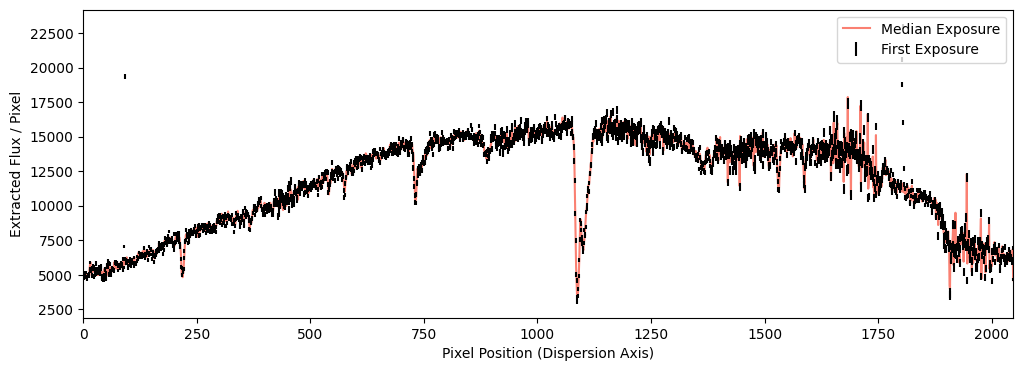

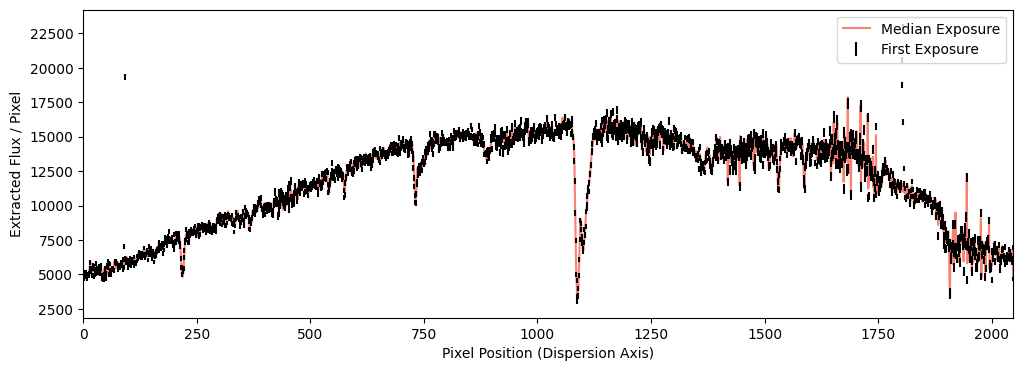

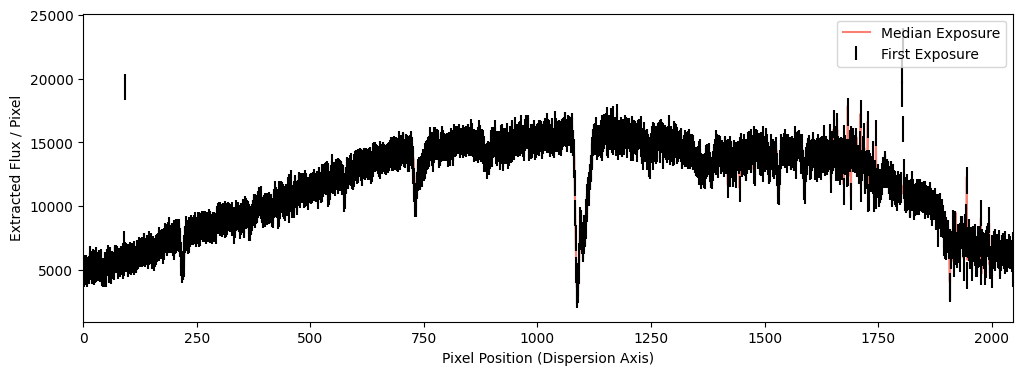

In [9]:
flux, err = ss.boxcar_extraction(
    images = science,
    backgrounds = backgrounds,
    RN = 1.0,
    debug = True,
)

flux, err = ss.boxcar_extraction(
    images = science,
    backgrounds = backgrounds,
    RN = 10,
    debug = True,
)

flux, err = ss.boxcar_extraction(
    images = science,
    backgrounds = backgrounds,
    RN = 100,
    debug = True,
)

If you feel your errors are too small or large, verify that your value for read noise is correct. Additionally, double-check that your instrument's gain has been properly accounted for!

### _Forgetting to Subtract Background_
We assume that your ```images``` have already been background-subtracted. If you did not subtract off your backgrounds, you may end up with an extracted flux that looks like this...

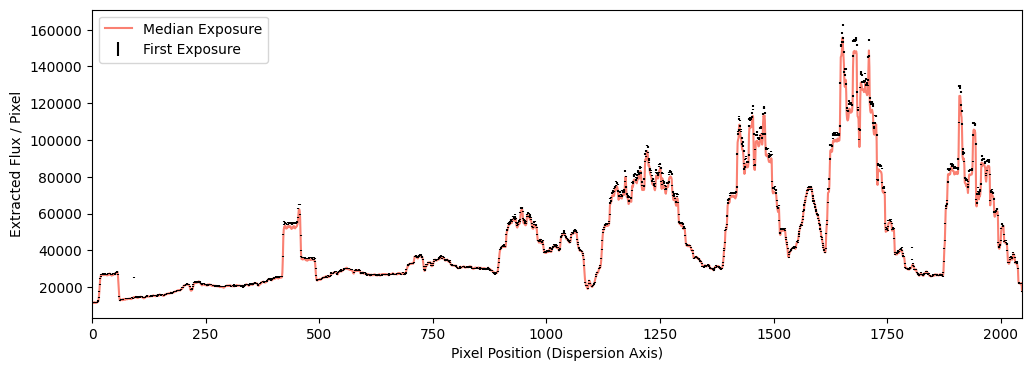

In [10]:
flux, err = ss.horne_extraction(
    science + backgrounds,
    backgrounds,
    debug = True,
)

These large spikes / blocky features are caused by background emissions that are contaminating the extraction. This is fixed by simply subtracting off the background exposures beforehand.